## Introduction to sentiment analysis

Sentiment analysis is an NLP technique that identifies the polarity of text, labeling it as positive, negative, or neutral.
For example, the tweet

>"@usyd.sudata I hate your coffee catchtups"
>
would be tagged as "Negative," while

>"@usyd.sudata I've sent you a DM"
>
would be "Neutral, and
>"Thanks to @usyd.sudata for running the best datathon ever"
>

would be "Positive."

This method processes large-scale data in real-time, making it easy to analyze tweets, reviews, or support tickets automatically, providing insights for data-driven decisions and automating tasks.

Common applications include:

- Analyzing social media mentions to track brand sentiment.
- Reviewing feedback to understand customer preferences.
- Flagging support tickets to address issues before they lead to churn.


## Getting Started

In [137]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import json

# Styling
color_pal = sns.color_palette("Set2")
plt.style.use('seaborn-v0_8-colorblind')

# Warnings control
import warnings
warnings.filterwarnings('ignore')


We'll start by using a pretrained model that is specifically trained on tweets.

Copy and paste this code and run it below:

```!pip install -q -y transformers, emoji==0.6.0```

In [138]:
from transformers import pipeline

The following code will take ~2-3 minutes to run as it has to download a model.

In [139]:
sentiment_pipeline = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis",device=0)

Ensure you are in the correct directory

In [140]:
os.getcwd()

'd:\\SUDATA_datathon_2024'

In [141]:
tweet_path = Path(r'D:\SUDATA_datathon_2024\stock-price-predictions\tweet') 
data_path = Path(r'D:\SUDATA_datathon_2024\stock-price-predictions\price')

Lets start by getting one day's worth of tweets and analysing the sentiment.

In [142]:
day = '2014-01-01'
file_path = tweet_path / 'AAPL' / day

In [143]:
data = []
with open(file_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))
tweet_df = pd.DataFrame(data)

In [144]:
tweet_df

,text,created_at,user_id_str
0,"[rt, AT_USER, summary, of, yesterday's, webcas...",Wed Jan 01 03:59:03 +0000 2014,1938270918
1,"[rt, AT_USER, summary, of, yesterday's, webcas...",Wed Jan 01 03:29:29 +0000 2014,1933063572
2,"[itv, will, boost, apple, URL, $, aapl, apple]",Wed Jan 01 18:08:47 +0000 2014,23059499
3,"[iphone, users, are, more, intelligent, than, ...",Wed Jan 01 01:52:31 +0000 2014,23954327
4,"[rt, AT_USER, summary, of, yesterday's, webcas...",Wed Jan 01 01:18:36 +0000 2014,1937591882
5,"[2013, wrap-up, and, trading, set, review, -, ...",Wed Jan 01 10:52:20 +0000 2014,23059499
6,"[apple, screwed, up, big, time, URL, $, amzn, ...",Wed Jan 01 15:01:12 +0000 2014,23669783
7,"[rt, AT_USER, summary, of, yesterday's, webcas...",Tue Dec 31 23:10:08 +0000 2013,1864753100


In [145]:
" ".join(tweet_df['text'].iloc[0])

"rt AT_USER summary of yesterday's webcast featuring $ aapl $ wynn $ goog $ lgf tradereducation options hedgingstrategies - - URL"

In [146]:
sentiment_pipeline(" ".join(tweet_df['text'].iloc[0]))

[{'label': 'NEU', 'score': 0.924950361251831}]

In [147]:
res = sentiment_pipeline(" ".join(tweet_df['text'].iloc[0]))
pd.Series(res)

0    {'label': 'NEU', 'score': 0.924950361251831}
dtype: object

In [148]:
def analyze_sentiment(text_tokens_list):
    # for each row in column, join the text tokens together into a single string
    texts = [' '.join(text_tokens) for text_tokens in text_tokens_list]
    # apply the sentiment analysis to the entire list
    results = sentiment_pipeline(texts)
    # extract labels and scores for each result
    sentiments = [(res['label'], res['score']) for res in results]

    return sentiments

In [149]:
sentiment_df = pd.DataFrame(analyze_sentiment(tweet_df['text']), columns=['sentiment', 'score'])

tweet_df = pd.concat([tweet_df, sentiment_df], axis=1)

In [150]:
tweet_df.head(5)

,text,created_at,user_id_str,sentiment,score
0,"[rt, AT_USER, summary, of, yesterday's, webcas...",Wed Jan 01 03:59:03 +0000 2014,1938270918,NEU,0.924950
1,"[rt, AT_USER, summary, of, yesterday's, webcas...",Wed Jan 01 03:29:29 +0000 2014,1933063572,NEU,0.924950
2,"[itv, will, boost, apple, URL, $, aapl, apple]",Wed Jan 01 18:08:47 +0000 2014,23059499,POS,0.614266
3,"[iphone, users, are, more, intelligent, than, ...",Wed Jan 01 01:52:31 +0000 2014,23954327,POS,0.879994
4,"[rt, AT_USER, summary, of, yesterday's, webcas...",Wed Jan 01 01:18:36 +0000 2014,1937591882,NEU,0.924950


## Getting the Majority Sentiment

Since we have multiple tweets on a given day, lets find a way to aggregate them and determine an overall sentiment for the day. We can start by trying the most frequent sentiment.



In [151]:
most_frequent_sentiment = tweet_df['sentiment'].mode().values.flatten()[0]

In [152]:
most_frequent_sentiment

'NEU'

Most of the time, the most frequent sentiment will be neutral, which is not very helpful. Lets try to only use positive / negative sentiments instead.

In [194]:
def determine_sentiment(sentiments):
    # Count occurrences of "POS" and "NEG"
    positive_count = sentiments.value_counts().get('POS', 0)
    negative_count = sentiments.value_counts().get('NEG', 0)

    return positive_count-negative_count

In [195]:
tweet_df['sentiment'].value_counts()

sentiment
NEU    5
POS    2
NEG    1
Name: count, dtype: int64

In [196]:
determine_sentiment(tweet_df['sentiment'])

1

### Getting the Majority Sentiment for all days

In [156]:
stock = 'AAPL'
stock_path = tweet_path / stock

In [157]:
# gets list of dates in this dir
files = [file.stem for file in stock_path.iterdir()]
files[:5]

['2014-01-01', '2014-01-02', '2014-01-03', '2014-01-04', '2014-01-05']

In [197]:
def get_sentiment(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))

    tweet_df = pd.DataFrame(data)
    tweet_date = file_path.stem

    # Apply sentiment analysis to the 'text' column and get all sentiments
    sentiments = [item[0] for item in analyze_sentiment(tweet_df['text'])]
    tweet_df['sentiment'] = sentiments

    sentiment = determine_sentiment(tweet_df['sentiment'])

    # Return the date and majority sentiment as a dictionary or other format
    return {'Date': str(tweet_date), 'Sentiment': sentiment}

In [198]:
get_sentiment(stock_path / files[3])

{'Date': '2014-01-04', 'Sentiment': 0}

In [199]:
all_sentiments = []
# Adds a progess bar for all the sentiments
# This will take some time # 1-2 minutes
for file in tqdm(files, "Processing all files"):
    file_path = stock_path / file
    try:
        result = get_sentiment(file_path)
        all_sentiments.append(result)
    except:
        print(f"Sentiment parsing failed for {file_path}")

Processing all files: 100%|██████████| 696/696 [01:32<00:00,  7.56it/s]


In [200]:
all_sentiments[:5]

[{'Date': '2014-01-01', 'Sentiment': 1},
 {'Date': '2014-01-02', 'Sentiment': 11},
 {'Date': '2014-01-03', 'Sentiment': 1},
 {'Date': '2014-01-04', 'Sentiment': 0},
 {'Date': '2014-01-05', 'Sentiment': 1}]

### Appending result to stock prices, and visualising

In [201]:
data_path = Path(r'D:\SUDATA_datathon_2024\stock-price-predictions\price\AAPL.csv') # Update your path here
df = pd.read_csv(data_path, header=0)

In [202]:
sentiment_df = pd.DataFrame(all_sentiments)

In [203]:
sentiment_df.head()

,Date,Sentiment
0,2014-01-01,1
1,2014-01-02,11
2,2014-01-03,1
3,2014-01-04,0
4,2014-01-05,1


In [204]:
sentiment_df = sentiment_df.sort_values('Date')

In [205]:
sentiment_df.set_index('Date', inplace=True)
sentiment_df.index = pd.to_datetime(sentiment_df.index)

In [206]:
sentiment_df

,Sentiment
Date,
2014-01-01,1
2014-01-02,11
2014-01-03,1
2014-01-04,0
2014-01-05,1
...,...
2015-12-27,3
2015-12-28,3
2015-12-29,2


In [207]:
df.set_index('Date', inplace=True)
df.index = pd.to_datetime(df.index)

In [209]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000
2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800
2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100
2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600
2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500
...,...,...,...,...,...,...
2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000
2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900
2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600


In [210]:
combined_df = pd.merge(df, sentiment_df, left_index=True, right_index=True, how='outer')

In [211]:
combined_df.head()

,Open,High,Low,Close,Adj Close,Volume,Sentiment
Date,,,,,,,
2012-09-04,95.108574,96.448570,94.928574,96.424286,87.121140,91973000.0,NaN
2012-09-05,96.510002,96.621429,95.657143,95.747147,86.509338,84093800.0,NaN
2012-09-06,96.167145,96.898575,95.828575,96.610001,87.288956,97799100.0,NaN
2012-09-07,96.864288,97.497147,96.538574,97.205711,87.827171,82416600.0,NaN
2012-09-10,97.207146,97.612854,94.585716,94.677139,85.542564,121999500.0,NaN


In [212]:
combined_df.tail()

,Open,High,Low,Close,Adj Close,Volume,Sentiment
Date,,,,,,,
2017-08-28,160.139999,162.000000,159.929993,161.470001,161.470001,25966000.0,NaN
2017-08-29,160.100006,163.119995,160.000000,162.910004,162.910004,29516900.0,NaN
2017-08-30,163.800003,163.889999,162.610001,163.350006,163.350006,27269600.0,NaN
2017-08-31,163.639999,164.520004,163.479996,164.000000,164.000000,26785100.0,NaN
2017-09-01,164.800003,164.940002,163.630005,164.050003,164.050003,16552800.0,NaN


In [218]:
df = combined_df.loc[(combined_df.index > '2014-01-01') & (combined_df.index < '2015-12-31')]
df

,Open,High,Low,Close,Adj Close,Volume,Sentiment
Date,,,,,,,
2014-01-02,79.382858,79.575714,78.860001,79.018570,73.522530,58671200.0,11.0
2014-01-03,78.980003,79.099998,77.204285,77.282860,71.907555,98116900.0,1.0
2014-01-04,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2014-01-05,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2014-01-06,76.778572,78.114288,76.228569,77.704285,72.299644,103152700.0,2.0
...,...,...,...,...,...,...,...
2015-12-26,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2015-12-27,NaN,NaN,NaN,NaN,NaN,NaN,3.0
2015-12-28,107.589996,107.690002,106.180000,106.820000,103.210999,26704200.0,3.0


Text(0, 0.5, 'Opening Price')

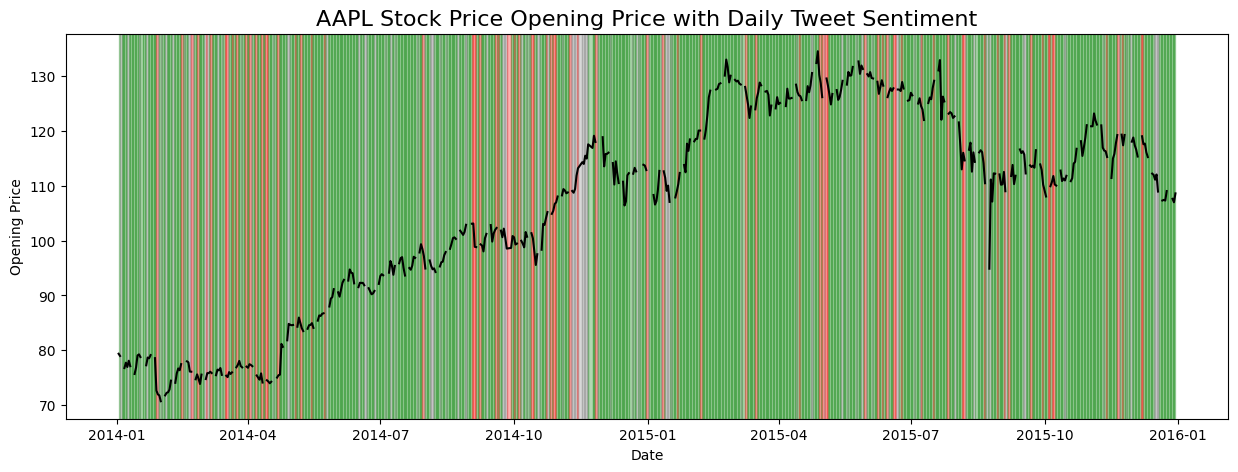

In [226]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.index, df['Open'], label='Opening Price', color='black')

for i in range(1, len(df)):
    prev_date = df.index[i - 1]
    curr_date = df.index[i]

    # Get the sentiment value for the current date
    sentiment_value = df['Sentiment'].iloc[i]

    # Determine the color based on the sentiment value
    if sentiment_value > 0:
        color = 'green'  # Positive sentiment
    elif sentiment_value < 0:
        color = 'red'    # Negative sentiment
    else:
        color = 'gray'   # Neutral sentiment

    # Use ax.axhspan to color the region between two dates
    ax.axvspan(prev_date, curr_date, color=color, alpha=0.3)

ax.set_title('AAPL Stock Price Opening Price with Daily Tweet Sentiment', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Opening Price')

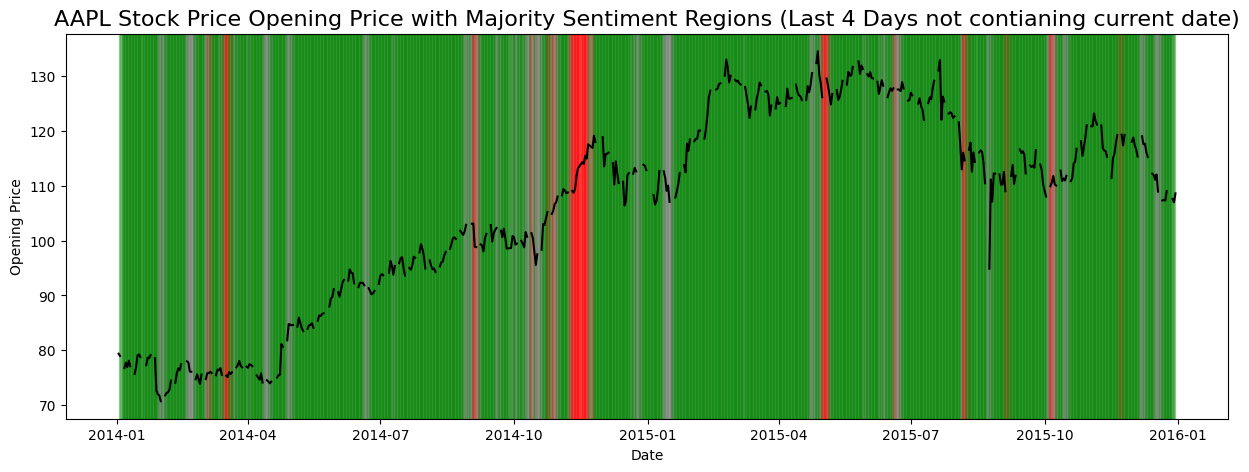

In [188]:
def majority_sentiment(sentiments):
    pos_count = (sentiments == 'POS').sum()
    neg_count = (sentiments == 'NEG').sum()
    neu_count = (sentiments == 'NEU').sum()

    if pos_count > neg_count and pos_count > neu_count:
        return 'POS'
    elif neg_count > pos_count and neg_count > neu_count:
        return 'NEG'
    else:
        return 'NEU'
    
    
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df.index, df['Open'], label='Opening Price', color='black')

for i in range(4, len(df)):  # Start at 4 since we need to look back 4 days
    prev_date = df.index[i - 4]  #
    curr_date = df.index[i]


    sentiment_last_five_days = df['Sentiment'].iloc[i-4:i]

    # Determine the majority sentiment over the last 5 days
    majority = majority_sentiment(sentiment_last_five_days)


    color = color_map.get(majority, 'gray')
    ax.axvspan(prev_date, curr_date, color=color, alpha=0.3)


ax.set_title('AAPL Stock Price Opening Price with Majority Sentiment Regions (Last 4 Days not contianing current date)', fontsize=16)
ax.set_xlabel('Date')
ax.set_ylabel('Opening Price')


plt.show()

In [190]:
df['Open']

Date
2014-01-02     79.382858
2014-01-03     78.980003
2014-01-04           NaN
2014-01-05           NaN
2014-01-06     76.778572
                 ...    
2015-12-26           NaN
2015-12-27           NaN
2015-12-28    107.589996
2015-12-29    106.959999
2015-12-30    108.580002
Name: Open, Length: 718, dtype: float64

In [193]:

ls = []
for i in range(4, len(df)):  # Start at 4 since we need to look back 4 days
    prev_date = df.index[i - 4]  #
    curr_date = df.index[i]
    sentiment_last_five_days = df['Sentiment'].iloc[i-4:i]
    print(sentiment_last_five_days)
    # Determine the majority sentiment over the last 5 days
    majority = majority_sentiment(sentiment_last_five_days)
    ls.append(majority)

ls

Date
2014-01-02    POS
2014-01-03    POS
2014-01-04    NEU
2014-01-05    POS
Name: Sentiment, dtype: object
Date
2014-01-03    POS
2014-01-04    NEU
2014-01-05    POS
2014-01-06    POS
Name: Sentiment, dtype: object
Date
2014-01-04    NEU
2014-01-05    POS
2014-01-06    POS
2014-01-07    POS
Name: Sentiment, dtype: object
Date
2014-01-05    POS
2014-01-06    POS
2014-01-07    POS
2014-01-08    POS
Name: Sentiment, dtype: object
Date
2014-01-06    POS
2014-01-07    POS
2014-01-08    POS
2014-01-09    NEU
Name: Sentiment, dtype: object
Date
2014-01-07    POS
2014-01-08    POS
2014-01-09    NEU
2014-01-10    POS
Name: Sentiment, dtype: object
Date
2014-01-08    POS
2014-01-09    NEU
2014-01-10    POS
2014-01-11    POS
Name: Sentiment, dtype: object
Date
2014-01-09    NEU
2014-01-10    POS
2014-01-11    POS
2014-01-12    POS
Name: Sentiment, dtype: object
Date
2014-01-10    POS
2014-01-11    POS
2014-01-12    POS
2014-01-13    POS
Name: Sentiment, dtype: object
Date
2014-01-11    POS
2014-

['POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEU',
 'NEU',
 'POS',
 'NEU',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEU',
 'NEU',
 'NEU',
 'NEU',
 'NEU',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEU',
 'NEU',
 'NEG',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEU',
 'POS',
 'POS',
 'NEG',
 'NEG',
 'NEG',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEU',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEU',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEU',
 'NEU',
 'NEU',
 'NEU',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'NEU',
 'NEU',
 'NEU',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
 'POS',
